# Human sorted dendritic cells and monocytes from PBMCs - Villani et al.

Here we analyse the discovery set from [Villani et al.](https://www.ncbi.nlm.nih.gov/pubmed/28428369) from a healthy donor (smart-seq2).
Link to the dataset: GEO=[gse94820](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse94820)

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb


import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# install some R packages through rpy2 (the rest are installed via conda)
packnames = ('RColorBrewer', 'gam', 'ggplot2', 'plyr')
from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(packnames))
results_file = './write/Villani_PBMCs_1.h5ad'  # the file that will store the analysis results

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

In [4]:
## Load previously processed dataset
#adata = sc.read_h5ad(results_file)
#adata.obs.index.names = ['barcode']

In [40]:
# Set up data loading
file = '../Munich/datasets/human/Villani/GSE94820_raw_expMatrix_DCnMono_discovery_set_submission.txt.gz'
adata = sc.read(filename=file, cache=True, delimiter='\t', first_column_names=True)
adata = adata.transpose()

... reading from cache file cache/..-Munich-datasets-human-Villani-GSE94820_raw_expMatrix_DCnMono_discovery_set_submission.h5ad


In [41]:
adata

AnnData object with n_obs × n_vars = 1140 × 26593 

In [11]:
adata.var.head()

""
1/2-SBSRNA4
5S_RRNA
5_8S_RRNA
7SK
A1BG


In [42]:
adata.var.index.names = ['gene_symbol']
adata.var.head()

""
gene_symbol
1/2-SBSRNA4
5S_RRNA
5_8S_RRNA
7SK
A1BG


In [43]:
adata.var_names_make_unique()

In [32]:
adata.obs.head()

""
index
CD141_P10_S73
CD141_P10_S74
CD141_P10_S75
CD141_P10_S76
CD141_P10_S77


In [44]:
adata.obs.index.names = ['barcode']
adata.obs.head()

""
barcode
CD141_P10_S73
CD141_P10_S74
CD141_P10_S75
CD141_P10_S76
CD141_P10_S77


In [82]:
cell_names = adata.obs.reset_index()
cell_names.head()

,barcode,n_genes,louvain_r1
0,CD141_P10_S73,5811,3
1,CD141_P10_S74,4779,8
2,CD141_P10_S75,5899,3
3,CD141_P10_S76,4178,3
4,CD141_P10_S77,6128,3


In [93]:
cell_names['cell_type'] = [i.split('_')[0] for i in cell_names['barcode']]
print(set(cell_names['cell_type']))

{'pDC', 'DoubleNeg', 'CD141', 'CD1C', 'Mono'}


In [94]:
cell_names.set_index('barcode', inplace = True)
adata.obs = cell_names

In [45]:
# Checking the total size of the data set
adata.shape

(1140, 26593)

# 1. Pre-processing and visualization

## 1.1 Quality control

Here we have gene expression levels in TPM (transcripts per million) as output of RSEM (v1.2.1). We don't calculate number of counts.

In [47]:
# Quality control - calculate QC covariates
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [49]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
sum(mt_gene_mask)
# no mito genes detected

0

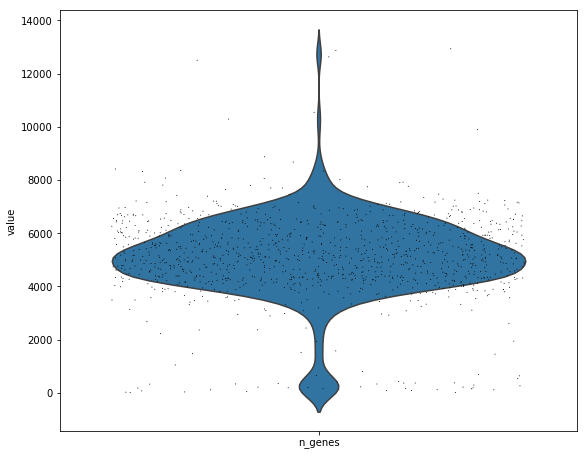

In [50]:
# Quality control - plot QC metrics
sc.pl.violin(adata, 'n_genes',  jitter=0.4)

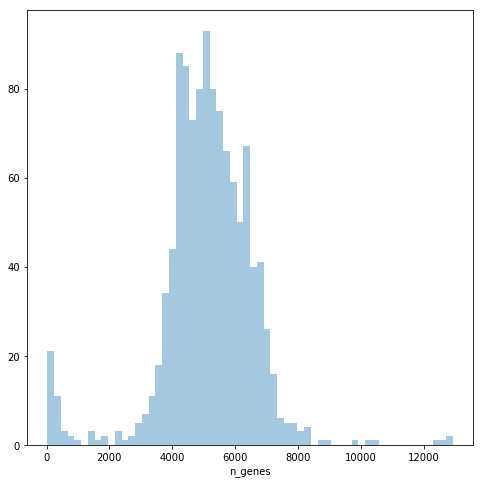

In [51]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()


From the histograms of the number of genes per cell, we can notice that there still is a small population showing n_genes < 2000 which should be filtered out. Also, we filter out cells with n_genes >10000

In [52]:
# Thresholding on number of genes
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 2000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = 10000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 1140
filtered out 44 cells that haveless than 2000 genes expressed
Number of cells after gene filter: 1096
filtered out 6 cells that havemore than 10000 genes expressed
Number of cells after gene filter: 1090


In [53]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 26593
filtered out 11264 genes that are detectedin less than 20 cells
Number of genes after cell filter: 15329


## 1.2 Normalization

In [54]:
sc.pp.log1p(adata)

## 1.3 Highly variable genes

In [55]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3999


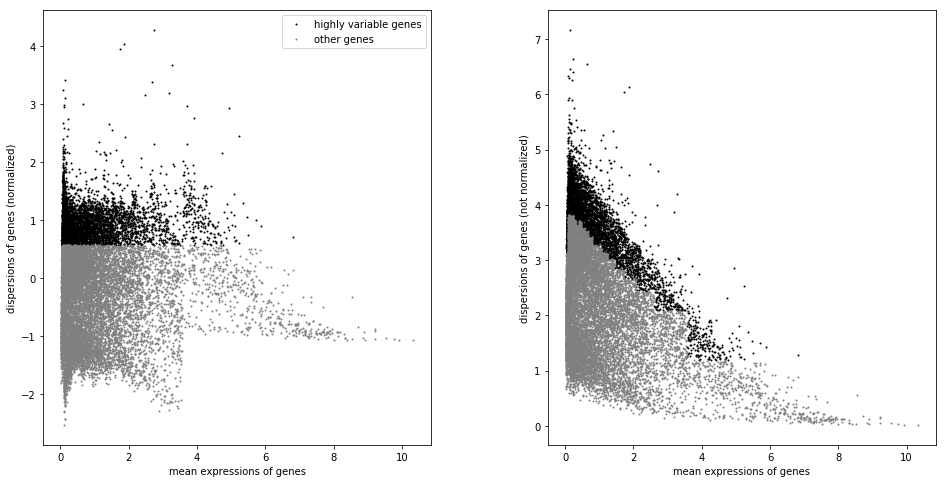

In [56]:
sc.pl.highly_variable_genes(adata)

# 2. Visualization

In [57]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.997035   0.99654585 0.9898264  0.9779032  0.9563038
     0.9423235  0.93408483 0.9032297  0.8776766  0.8742227  0.86646426
     0.8617306  0.8438482  0.80101335]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:06)


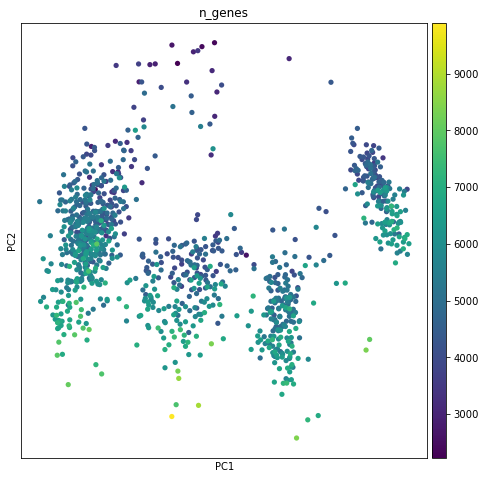

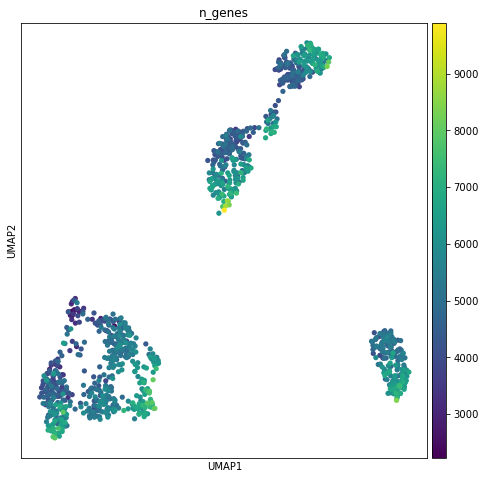

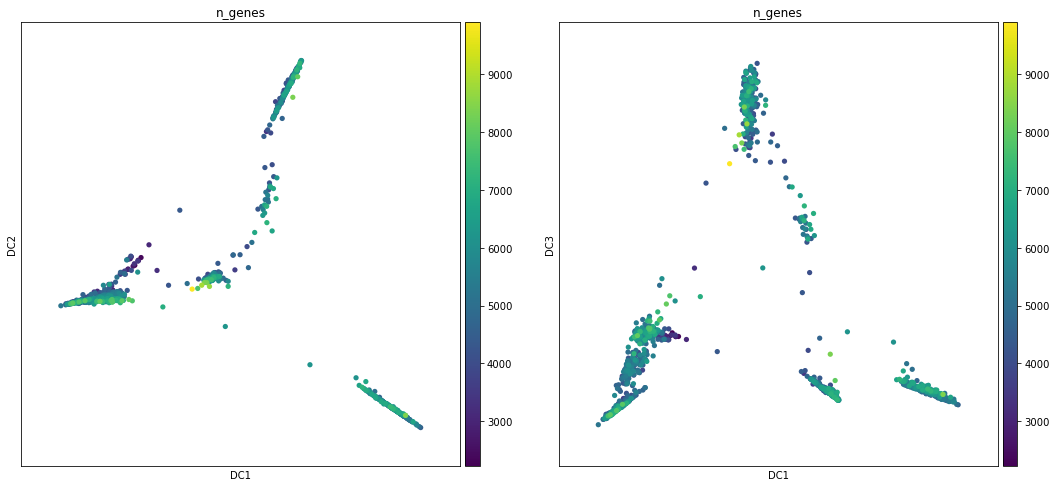

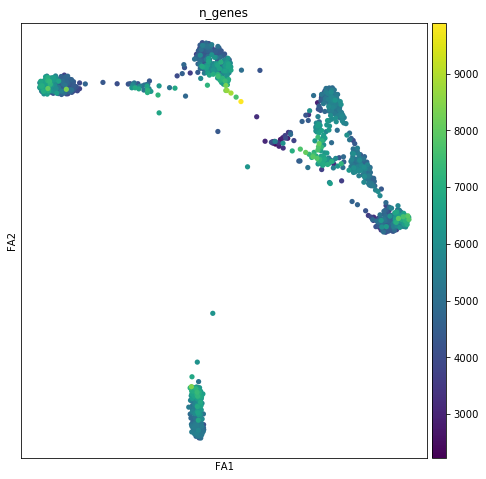

In [58]:
sc.pl.pca_scatter(adata, color='n_genes')
sc.pl.umap(adata, color='n_genes')
sc.pl.diffmap(adata, color='n_genes', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_genes')

In [59]:
adata.write(results_file)

# 3. Clustering

In [60]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_type' as categorical


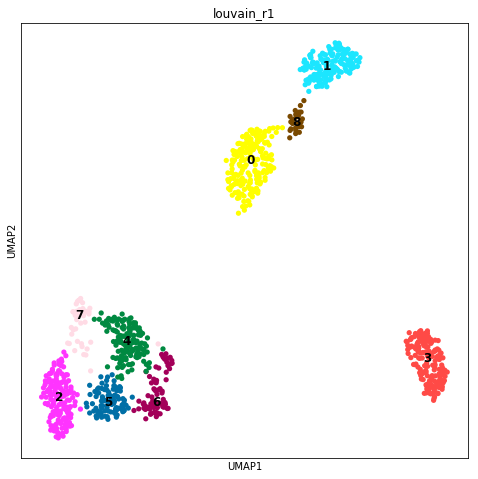

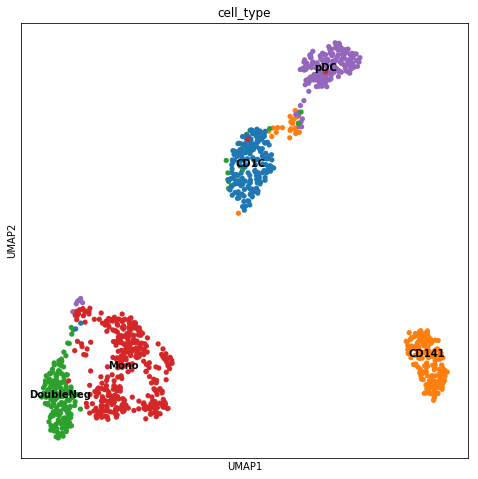

In [95]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color= 'louvain_r1', palette=sc.pl.palettes.default_64, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color= 'cell_type', legend_loc='on data')


# 4. Marker genes and cluster annotation (r 1)

In [63]:
#Calculate marker genes r1
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


## 4.1 List of markers of cell types from PanglaoDB
Here we use a list of markers for 34 different cell types from PanglaoDB, considering all cell types in "immune system" + "blood" + "bone". We manually checked that all cell types were possible for healthy tissue, so we excluded:
* __Myeloid derived suppressor cells__, description: MDSC are not present at steady state in healthy individuals and appear in cancer and pathological conditions associated with chronic inflammation or stress. 
* __Red pulp macrophages__, description: Present in the red pulp of the spleen. They are necessary for maintaining blood homeostasis by performing phagocytosis upon injured and senescent erythrocytes and blood-borne particulates.

In [65]:
markers_df = pd.read_csv('../Munich/Immune_markers_PanglaoDB.txt', delimiter='\t')
markers_df.shape

(2089, 14)

In [66]:
markers_df = markers_df[markers_df['cell.type'] != 'Myeloid-derived suppressor cells']
markers_df.shape

(2072, 14)

In [67]:
markers_df = markers_df[markers_df['cell.type'] != 'Red pulp macrophages']
markers_df.shape

(2060, 14)

In [68]:
markers_df_hum = markers_df[(markers_df['species'] == 'Hs') | (markers_df['species'] == 'Mm Hs')]
markers_df_hum.shape

(1907, 14)

In [69]:
cell_types = list(markers_df_hum['cell.type'].unique())

In [70]:
markers_dict = {}
for ctype in cell_types:
    df = markers_df_hum[markers_df_hum['cell.type'] == ctype]
    markers_dict[ctype] = df['official.gene.symbol'].to_list()

In [71]:
cell_annotation = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1')

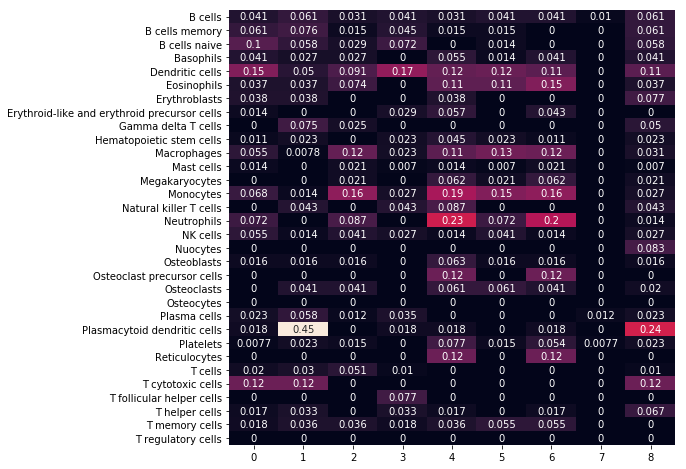

In [72]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, markers_dict, key='rank_genes_r1', normalize='reference')
sb.heatmap(cell_annotation_norm, cbar=False, annot=True)

# 5. Plot makers of subtypes

In [73]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Monocytes: CD14+ and CD16+

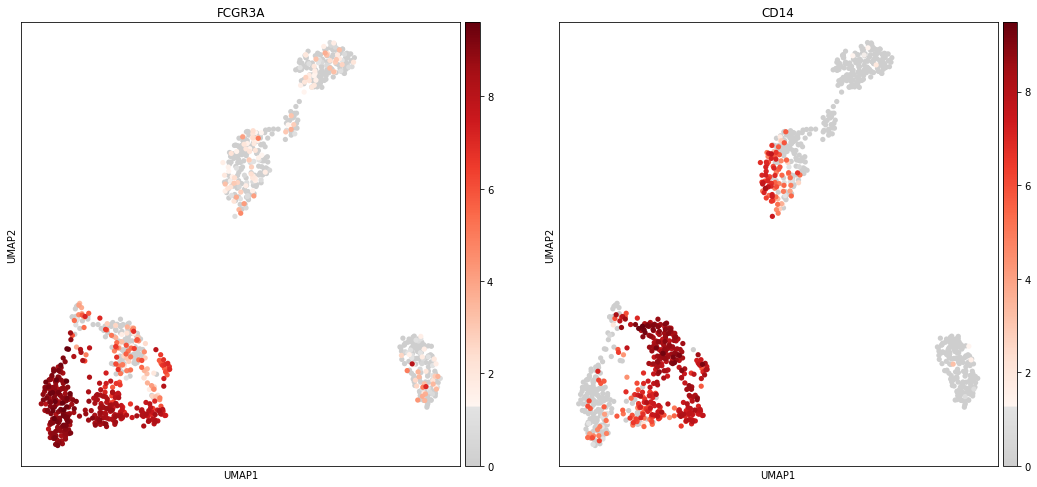

In [75]:
sc.pl.umap(adata, color=['FCGR3A','CD14'], use_raw=False, color_map=mymap)


## Monocyte-derived Dendritic cells

Markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

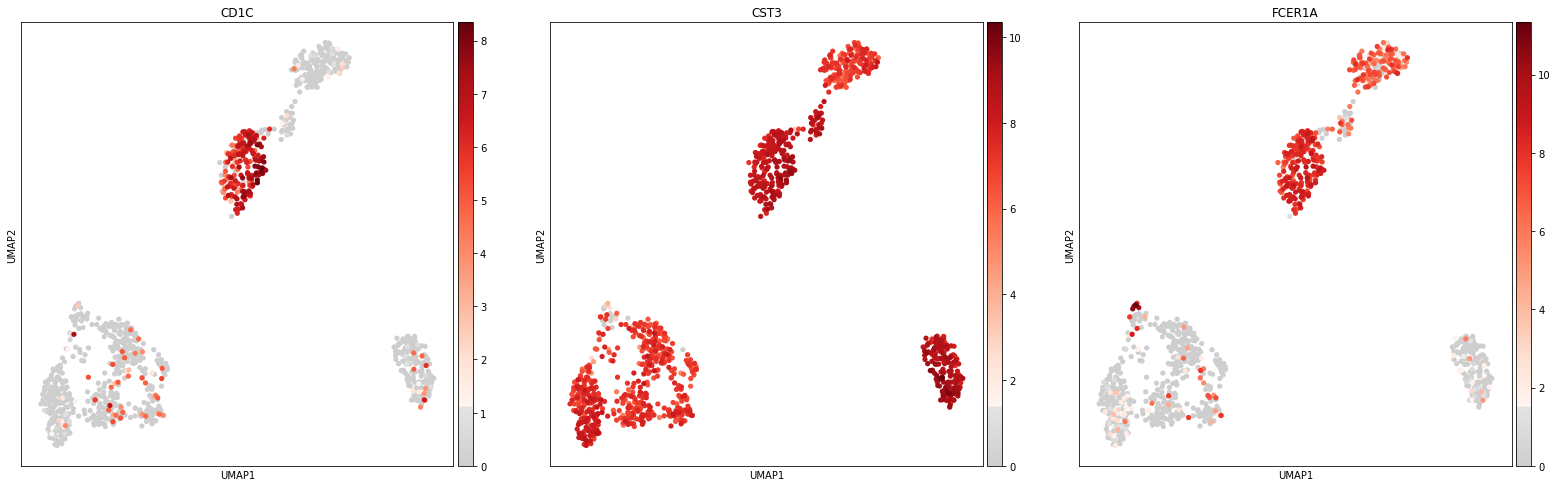

In [77]:
sc.pl.umap(adata, color=['CD1C', 'CST3', 'FCER1A'], use_raw=False, color_map=mymap)

## Plasmacytoid dendritic cells

Here we use markers from [Sinha et al.](https://www.ncbi.nlm.nih.gov/pubmed/29361178)

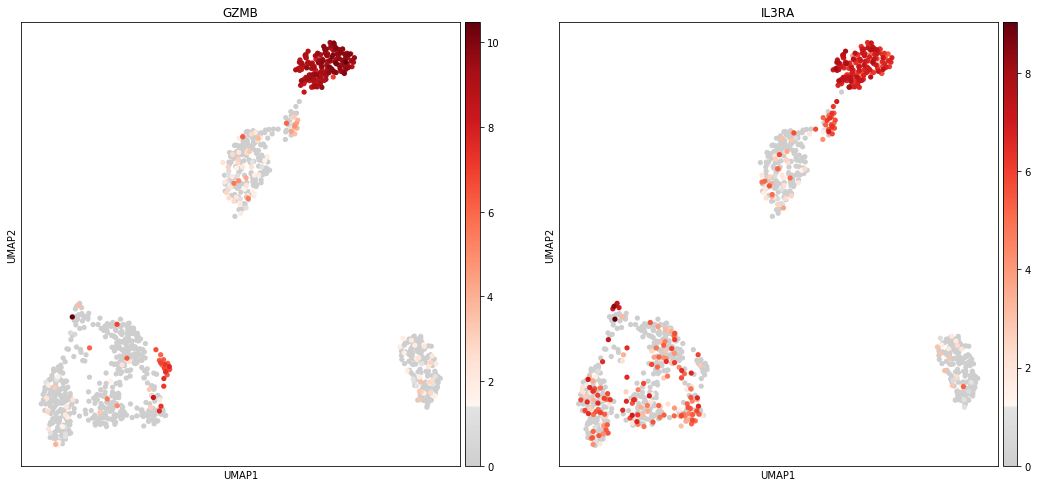

In [78]:
sc.pl.umap(adata, color=['GZMB', 'IL3RA'], use_raw=False, color_map=mymap)

# 7. Final cell-type annotation

We exclude clusters 7 and 8 that are a mixture of cell types

In [106]:
adata = adata[adata.obs['louvain_r1'] != '7']
adata = adata[adata.obs['louvain_r1'] != '8']

In [119]:
# Categories to rename
adata.obs['final_annotation'] = adata.obs['louvain_r1']
adata.rename_categories('final_annotation', ['Monocyte-derived dendritic cells, 1',
                                             'Plasmacytoid dendritic cells',
                                             'Monocyte-derived dendritic cells, 2',
                                             'Monocyte-derived dendritic cells, 3',
                                             'CD14+ Monocytes',
                                             'CD16+ Monocytes,1',
                                             'CD16+ Monocytes,2'])

In [120]:
tmp = adata.obs['final_annotation']
tmp = ['Monocyte-derived dendritic cells' if item.startswith('Monocyte-derived') else item for item in tmp]
tmp = ['CD16+ Monocytes' if item.startswith('CD16+ Monocytes') else item for item in tmp]
adata.obs['final_annotation'] = tmp

... storing 'final_annotation' as categorical


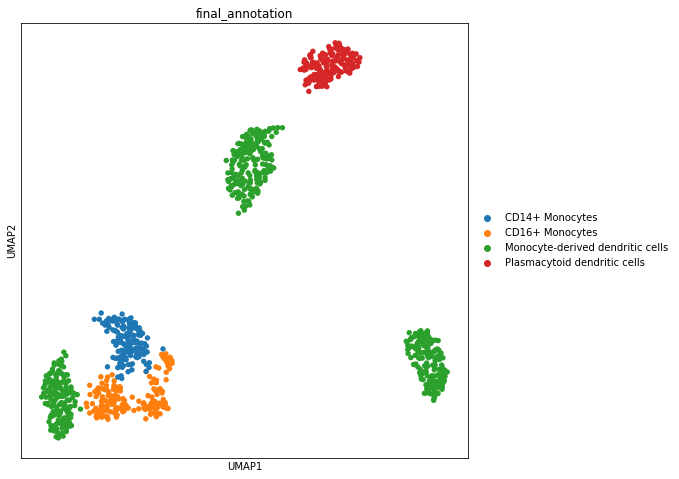

In [121]:
sc.pl.umap(adata, color='final_annotation')

In [122]:
# save final result
adata.write(results_file)